In [5]:
import os
from fig_gen  import FigureGenerator as fg
from sklearn.metrics import r2_score
import pwlf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression
%matplotlib inline
import missingno as msno
np.random.seed(19)
from matplotlib.pyplot import figure
data_directory = '/work2/05067/nagyz/austin_energy/data/'
filepaths = [os.path.join(data_directory,f) for f in os.listdir(data_directory) if f.endswith('.csv')]
from datetime import datetime 
from Graphs import load_data,load_graph_kwh,yearly_graph_kwh,load_graph_count,monthly_graph_kwh,daily_graph_kwh
from Graphs import load_graph_kwh_and_count,yearly_graph_kwh_and_count,monthly_graph_kwh_and_count,daily_graph_kwh_and_count
from agg_and_heatmap_functions import length,prav3,prav2,prav1,dinostorm,plot_aggraph,heatmap,finalheatmap
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, SGDRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge,Lasso
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
weather_daily=pd.read_csv('Austin_weather_daily.csv')
weather_daily['time']=pd.to_datetime(weather_daily['time'],utc=True)
weather_daily1=weather_daily.set_index('time',drop=True)
weather_austin_daily=weather_daily1['tavg']
cool_points=weather_austin_daily[weather_austin_daily<15]['2017-01-01 00:00:00+00:00':'2021-01-31 00:00:00+00:00']
# NOT UTC TIME
weather_Pred=pd.read_csv('Austin_hourly.csv')
weather_Pred['time']=pd.to_datetime(weather_Pred['time'])
weather_pred1=weather_Pred.set_index('time',drop=True)
weather_austin_hourl_pred=weather_pred1['temp']
import geopandas as gpd
from sklearn.preprocessing import MinMaxScaler

In [6]:
id_list = pd.read_csv('buildingInfo.csv')

#id_list.drop('Unnamed: 0',axis=1,inplace=True)
id_list['buildingType'].unique()
res_type = ['SINGLE FAMILY', 'MULTIFAMILY',  'FOURPLEX', 
            'DUPLEX', 'CONDOS', 'CONDO (STACKED)', 
            '1 FAM DWELLING, ACCESSORY DWELLING UNIT',
            'TOWNHOMES','MOHO SINGLE PP', 
            '1 FAM DWELLING, GARAGE APARTMENT', 'MOHO DOUBLE PP',
            'MOHO SINGLE REAL', 'MOHO DOUBLE REAL', 'TRIPLEX', 
            '1 FAM DWELLING, MOHO DOUBLE REAL',
           '1 FAM DWELLING, MOHO SINGLE REAL']
res_type_id_list = id_list[id_list['buildingType'].isin(res_type)].copy()
res_type_id_list[['Service Point','zipCode']].head()

,Service Point,zipCode
0,-1612,78759
3,-1609,78759
4,-1608,78759
13,-1599,78759
14,-1598,78759


In [7]:
single_Famiy=res_type_id_list[res_type_id_list['buildingType']=='SINGLE FAMILY']
single_Famiy[single_Famiy['zipCode']==78758]

,Service Point,zipCode,rate,buildingType,meterCount,squareFt
29,-1583,78758,E-SEC2,SINGLE FAMILY,14,7042.125
30,-1582,78758,E-SEC1,SINGLE FAMILY,25,19913.375
31,-1581,78758,E-RES,SINGLE FAMILY,5363,8224307.500


In [8]:
def prepare_data(service_point):
    sample=load_data(service_point)
    sample=sample.set_index(sample[sample.columns[0]])
    sample=sample[sample.columns[1:2]]
    sample=sample.resample('D').sum()
    return sample
def make_features(dataframe,time_level):
    s=dataframe
    start_time=s.index[0]
    end_time=s.index[-1]
    example_ts=s
    example_ts['dayofyear_cos']=np.cos(example_ts.index.dayofyear*(2.*np.pi/365))
    example_ts['dayofyear_sim']=np.sin(example_ts.index.dayofyear*(2.*np.pi/365))
    example_ts['month_cos']=np.cos(example_ts.index.month*(2.*np.pi/12))
    example_ts['month_sin']=np.sin(example_ts.index.month*(2.*np.pi/12))
    example_ts['year'] = example_ts.index.year

    for ts in example_ts.index:
        if time_level=='hourly':
             example_ts.loc[ts:ts, 'TMP'] = weather_austin_hourl_pred[weather_austin_hourl_pred.index == ts] 
        else:
             example_ts.loc[ts:ts, 'TMP'] = weather_austin_hourl_pred[weather_austin_hourl_pred.index == ts]

    return example_ts

In [9]:
def function_1581(servicepoint,metric):  
    s=prepare_data(servicepoint)
    s = s.rename(columns={list(s.columns.values)[0]: 'Energy_kwh'})
    train_set=s[:'2021-02-10']
    test_set=s['2021-02-11':'2021-02-19']
    k=5
    residential_train_Data_servicepoint=make_features(train_set,'daily')
    residential_test_data_service_point=make_features(test_set,'daily')
    resi_winter_temp=residential_test_data_service_point['TMP']
    resi_below_5=residential_train_Data_servicepoint[residential_train_Data_servicepoint['TMP']<5]
    Q1=resi_below_5[resi_below_5.columns[0]].quantile(0.25)
    Q3=resi_below_5[resi_below_5.columns[0]].quantile(0.75)
    if servicepoint==-1581:
        bad_value=resi_below_5[resi_below_5.columns[0]].quantile(0.80)
    else:
        bad_value=resi_below_5[resi_below_5.columns[0]].quantile(0.98)
    IQR=Q3-Q1
    th=Q1-1.5*IQR
    indexAge = resi_below_5[ ((resi_below_5['Energy_kwh'] <th ) & (resi_below_5['TMP'] < 0)) |(resi_below_5['Energy_kwh']>bad_value)  ].index
    resi_below_5_1=resi_below_5.drop(indexAge)
    q=resi_below_5_1[resi_below_5_1['TMP']<5]
    
    
    
    m, b = np.polyfit(q['TMP'], q['Energy_kwh'], 1)
    train_below_5=q[q.columns[k:]]
    test_below_5=q['Energy_kwh']
    lr_5=LinearRegression()
    lr_5.fit(train_below_5,test_below_5)
    resi_test_more_than_5=residential_train_Data_servicepoint[residential_train_Data_servicepoint['TMP']>5]
    train_above_5=resi_test_more_than_5[resi_test_more_than_5.columns[k:]]
    test_above_5=resi_test_more_than_5['Energy_kwh']
    lr_above_5=LinearRegression()
    lr_above_5.fit(train_above_5,test_above_5)
    winter_test_data=residential_test_data_service_point[residential_test_data_service_point.columns[k:]]
    winter_data_below_5=winter_test_data[winter_test_data['TMP']<5]
    winter_data_above_5=winter_test_data[winter_test_data['TMP']>5]
    
    
    pred_below_5=lr_5.predict(winter_data_below_5)
    a=pred_below_5
    frames=[a]
    predictions = np.concatenate(frames)
    if metric=='perc_diff':
        result=100*(pred_below_5-residential_test_data_service_point['Energy_kwh']['2021-02-11':'2021-02-19'])/residential_test_data_service_point['Energy_kwh']['2021-02-11':'2021-02-19']
    elif metric=='difference(z_score)':
        metric_result=pred_below_5-residential_test_data_service_point['Energy_kwh']['2021-02-11':'2021-02-19']
        result=(metric_result-metric_result.mean())/metric_result.std()
    elif metric=='perc_diff(reverse)':
        result=100*(residential_test_data_service_point['Energy_kwh']['2021-02-11':'2021-02-19']-pred_below_5)/pred_below_5
    di=pd.DataFrame(result)
    di['timestamp']=di.index
    di1=di.rename(columns={'Energy_kwh':servicepoint})
    return di1.reset_index().iloc[:,1:].set_index('timestamp',drop=True)

In [10]:
def function(servicepoint,metric):  
    s=prepare_data(servicepoint)
    s = s.rename(columns={list(s.columns.values)[0]: 'Energy_kwh'})
    train_set=s[:'2021-02-10']
    test_set=s['2021-02-11':'2021-02-19']
    k=5
    residential_train_Data_servicepoint=make_features(train_set,'daily')
    residential_test_data_service_point=make_features(test_set,'daily')
    resi_winter_temp=residential_test_data_service_point['TMP']
    resi_below_5=residential_train_Data_servicepoint[residential_train_Data_servicepoint['TMP']<5]
    Q1=resi_below_5[resi_below_5.columns[0]].quantile(0.25)
    Q3=resi_below_5[resi_below_5.columns[0]].quantile(0.75)
    IQR=Q3-Q1
    th=Q1-1.5*IQR
    Index=resi_below_5[(resi_below_5['Energy_kwh'] <th ) & (resi_below_5['TMP'] < 5) ].index
    resi_below_5_1=resi_below_5.drop(Index)
    q=resi_below_5_1[resi_below_5_1['TMP']<5]
    m, b = np.polyfit(q['TMP'], q['Energy_kwh'], 1)
    train_below_5=q[q.columns[k:]]
    test_below_5=q['Energy_kwh']
    lr_5=LinearRegression()
    lr_5.fit(train_below_5,test_below_5)
    resi_test_more_than_5=residential_train_Data_servicepoint[residential_train_Data_servicepoint['TMP']>5]
    train_above_5=resi_test_more_than_5[resi_test_more_than_5.columns[k:]]
    test_above_5=resi_test_more_than_5['Energy_kwh']
    lr_above_5=LinearRegression()
    lr_above_5.fit(train_above_5,test_above_5)
    winter_test_data=residential_test_data_service_point[residential_test_data_service_point.columns[k:]]
    winter_data_below_5=winter_test_data[winter_test_data['TMP']<5]
    winter_data_above_5=winter_test_data[winter_test_data['TMP']>5]
    pred_below_5=lr_5.predict(winter_data_below_5)
    a=pred_below_5
    frames=[a]
    predictions = np.concatenate(frames)
    if metric=='perc_diff':
        result=100*(pred_below_5-residential_test_data_service_point['Energy_kwh']['2021-02-11':'2021-02-19'])/residential_test_data_service_point['Energy_kwh']['2021-02-11':'2021-02-19']
    elif metric=='difference(z_score)':
        metric_result=pred_below_5-residential_test_data_service_point['Energy_kwh']['2021-02-11':'2021-02-19']
        result=(metric_result-metric_result.mean())/metric_result.std()
    elif metric=='perc_diff(reverse)':
        result=100*(residential_test_data_service_point['Energy_kwh']['2021-02-11':'2021-02-19']-pred_below_5)/pred_below_5
    di=pd.DataFrame(result)
    di['timestamp']=di.index
    di1=di.rename(columns={'Energy_kwh':servicepoint})
    return di1.reset_index().iloc[:,1:].set_index('timestamp',drop=True)

In [11]:
def preprocess_data(servicepoint):
    s=prepare_data(servicepoint)
    s = s.rename(columns={list(s.columns.values)[0]: 'Energy_kwh'})
    train_set=s['2018-01-01':'2021-02-10']
    test_set=s['2021-02-11':'2021-02-19']
    residential_train=make_features(train_set,'daily')
    residential_test=make_features(test_set,'daily')
    Q1=residential_train[residential_train.columns[0]].quantile(0.25)
    Q3=residential_train[residential_train.columns[0]].quantile(0.75)
    IQR=Q3-Q1
    lower_bound=Q1-1.5*IQR
    upper_bound=Q3+1.5*IQR
    if servicepoint==-1581:
        Index=residential_train[((residential_train['Energy_kwh'] <lower_bound ) & (residential_train['TMP'] <=5))
                               | (residential_train['Energy_kwh'] >upper_bound )].index
    else:
        Index=residential_train[(residential_train['Energy_kwh'] <lower_bound ) & (residential_train['TMP'] <=5) ].index
    cleaned_train=residential_train.drop(Index)
    cleaned_train1=pd.concat([cleaned_train,residential_test])
    return cleaned_train1

In [20]:
def prediction_model(service_point,visualize=True):
    q=preprocess_data(service_point)
    train_below_5=q[q['TMP']<=5][['Energy_kwh','TMP','year']][:'2021-02-10']
    train_above_5=q[q['TMP']>5][['Energy_kwh','TMP','year']][:'2021-02-10']


    m_below,b_below = np.polyfit(train_below_5['TMP'], train_below_5['Energy_kwh'], 1)
    if visualize:
        plt.scatter(train_below_5['TMP'], train_below_5['Energy_kwh'])
        plt.plot(train_below_5['TMP'], m_below*train_below_5['TMP'] +b_below,color='red')
        plt.show()
        print(train_below_5['TMP'].corr(train_below_5['Energy_kwh']))

    m_above,m1_above,b_above = np.polyfit(train_above_5['TMP'], train_above_5['Energy_kwh'], 2)
    if visualize:
        plt.scatter(train_above_5['TMP'], train_above_5['Energy_kwh'])
        plt.plot(train_above_5['TMP'], m_above*train_above_5['TMP']**2 + m1_above*train_above_5['TMP'] + b_above,color='red')
        plt.show()
        print(train_above_5['TMP'].corr(train_above_5['Energy_kwh']))

    test_below_5=q[q['TMP']<=5][['Energy_kwh','TMP','year']]
    test_above_5=q[q['TMP']>5][['Energy_kwh','TMP','year']]


    Lr_below_5=LinearRegression().fit(train_below_5[train_below_5.columns[1:]], train_below_5[['Energy_kwh']])


    polynomial_features= PolynomialFeatures(degree=2)
    x_poly = polynomial_features.fit_transform(train_above_5[['TMP']])
    Lr_above_5=LinearRegression().fit(x_poly, train_above_5[['Energy_kwh']])

    below_5_predictions=pd.DataFrame(Lr_below_5.predict(test_below_5[test_below_5.columns[1:]]),
                                     index=test_below_5.index)
    below_5_predictions1=test_below_5.merge(below_5_predictions,how='inner',left_index=True,right_index=True)


    test_x_poly = polynomial_features.fit_transform(test_above_5[['TMP']])
    above_5_predictions=pd.DataFrame(Lr_above_5.predict(test_x_poly),
                                     index=test_above_5.index)
    above_5_predictions1=test_above_5.merge(above_5_predictions,how='inner',left_index=True,right_index=True)
    total_predictions=pd.concat([above_5_predictions1,below_5_predictions1])[['Energy_kwh','TMP',0]]
    total_predictions1=total_predictions[total_predictions[0]>0].sort_index().rename(
                                                            columns={0: 'prediction'})
    total_predictions1['difference']=abs(total_predictions1['prediction']-total_predictions1['Energy_kwh'])
    return total_predictions1

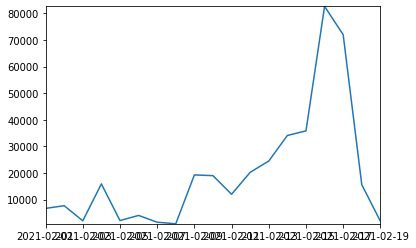

In [10]:
s=function(-1583,'perc_diff')
s1=function(-1582,'perc_diff')
s2=function_1581(-1581,'perc_diff')
#combined_df=s1.merge(s,left_index=True,right_index=True).merge(s2,left_index=True,right_index=True).T
#combined_df.columns=['11th','12th','13th','14th','15th','16th','17th','18th','19th']
#combined_df

,11th,12th,13th,14th,15th,16th,17th,18th,19th
-1582,-21.589770,-34.753263,-37.885640,-38.387264,5.353555,170.021296,28.405144,-30.520109,-37.676774
-1583,-34.537815,-34.465613,-32.901251,-36.694012,-23.122697,-0.569165,-9.383230,-26.615415,-24.601349
-1581,-16.767091,-16.349632,-16.880691,-21.604099,39.423655,139.775125,107.566966,12.487172,-0.446996


In [16]:
s2

,-1581
timestamp,
2021-02-11,20.144786
2021-02-12,19.545201
2021-02-13,20.308989
2021-02-14,27.557690
2021-02-15,-28.276159
2021-02-16,-58.294256
2021-02-17,-51.822777
2021-02-18,-11.100974
2021-02-19,0.449003


In [18]:
a=detect_outage(-1583)
a1=detect_outage(-1582)
a2=detect_outage(-1581)
combined_a=a1.merge(a,left_index=True,right_index=True).merge(a2,left_index=True,right_index=True).T
combined_a.columns=['11th','12th','13th','14th','15th','16th','17th','18th','19th']
combined_a

KeyError: 'year'

In [12]:

combined_df.columns=['11th','12th','13th','14th','15th','16th','17th','18th','19th']
combined_df

,11th,12th,13th,14th,15th,16th,17th,18th,19th
-1582,-21.589770,-34.753263,-37.885640,-38.387264,5.353555,170.021296,28.405144,-30.520109,-37.676774
-1583,-34.537815,-34.465613,-32.901251,-36.694012,-23.122697,-0.569165,-9.383230,-26.615415,-24.601349
-1581,-16.767091,-16.349632,-16.880691,-21.604099,39.423655,139.775125,107.566966,12.487172,-0.446996


Text(114.0, 0.5, 'servicepoint')

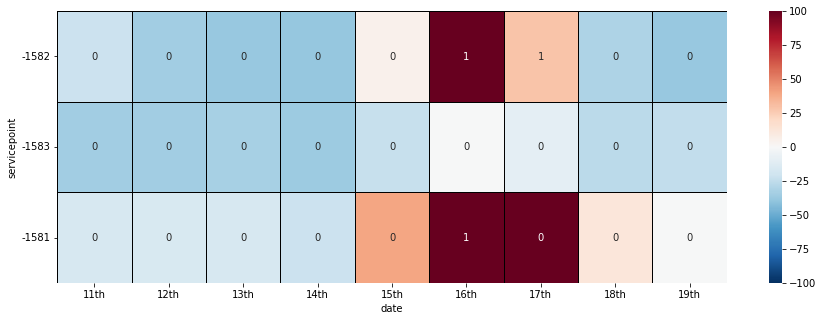

In [14]:
fig, ax1 = plt.subplots(figsize=(15,5))
sns.heatmap(combined_df,vmin=-100,vmax=100,cmap='RdBu_r',ax=ax1,linewidths = 1,annot=np.array(combined_a),linecolor='black')
degrees = 0
plt.yticks(rotation=degrees)
plt.xticks(rotation=degrees)
plt.xlabel('date')
plt.ylabel('servicepoint')


Text(114.0, 0.5, 'servicepoint')

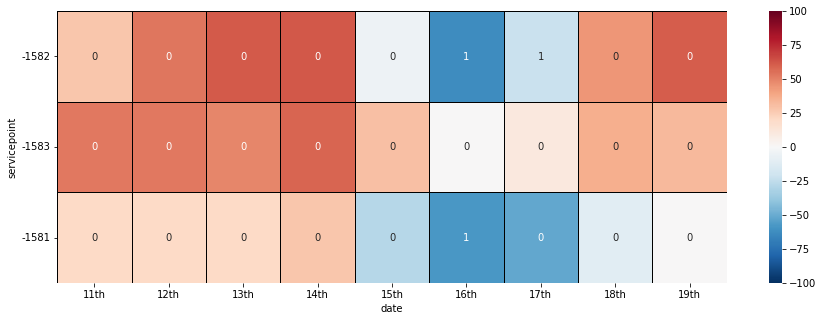

In [15]:
s=function(-1583,'perc_diff(reverse)')
s1=function(-1582,'perc_diff(reverse)')
s2=function_1581(-1581,'perc_diff(reverse)')
combined_df=s1.merge(s,left_index=True,right_index=True).merge(s2,left_index=True,right_index=True).T
combined_df.columns=['11th','12th','13th','14th','15th','16th','17th','18th','19th']
fig, ax1 = plt.subplots(figsize=(15,5))
sns.heatmap(combined_df,vmax=100,vmin=-100,cmap='RdBu_r',ax=ax1,linewidths = 1,annot=np.array(combined_a),linecolor='black')
degrees = 0
plt.yticks(rotation=degrees)
plt.xticks(rotation=degrees)
plt.xlabel('date')
plt.ylabel('servicepoint')


Text(114.0, 0.5, 'servicepoint')

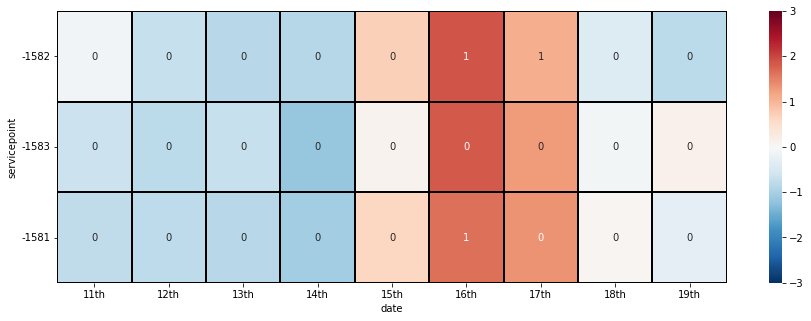

In [18]:
s=function(-1583,'difference(z_score)')
s1=function(-1582,'difference(z_score)')
s2=function_1581(-1581,'difference(z_score)')
combined_df=s1.merge(s,left_index=True,right_index=True).merge(s2,left_index=True,right_index=True).T
combined_df.columns=['11th','12th','13th','14th','15th','16th','17th','18th','19th']
fig, ax1 = plt.subplots(figsize=(15,5))
sns.heatmap(combined_df,vmin=-3,vmax=3,cmap='RdBu_r',ax=ax1,linewidths = 1,annot=np.array(combined_a),linecolor='black')
degrees = 0
plt.yticks(rotation=degrees)
plt.xticks(rotation=degrees)
plt.xlabel('date')
plt.ylabel('servicepoint')